# Lecture 5 Slides. Elemental Confounds

https://www.youtube.com/watch?v=UpP-_mBvECI&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=7

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import altair as alt

alt.renderers.enable("mimetype")  # support rendering on github
import numpy as np
import pandas as pd

import statreth as sr

## The Fork

`X <- Z -> Y`

`X` and `Y` are associated (correlated) due to common confounder `Z`. Conditioning (stratifying) on `Z` removes association between `X` and `Y`

Example: Casual effect of marriage rate on divorce rate

### Load Data

In [3]:
waffle_df = pd.read_csv("../data/WaffleDivorce.csv", delimiter=";")
waffle_df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


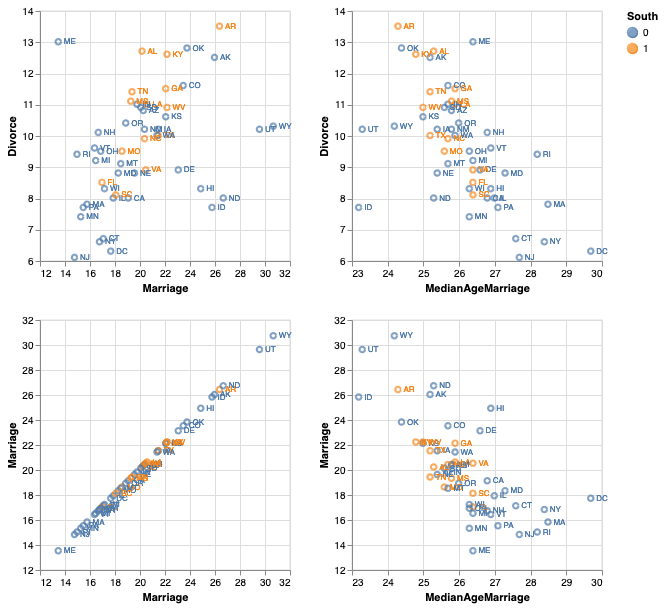

In [4]:
points_chart = (
    alt.Chart(waffle_df)
    .mark_point()
    .encode(
        alt.X(alt.repeat("column"), type="quantitative", scale=alt.Scale(zero=False)),
        alt.Y(alt.repeat("row"), type="quantitative", scale=alt.Scale(zero=False)),
        color="South:N",
    )
    .properties(
        width=250,
        height=250,
    )
)

label_chart = points_chart.mark_text(
    align="left", baseline="middle", dx=5, size=8
).encode(text="Loc")

(points_chart + label_chart).repeat(
    row=["Divorce", "Marriage"], column=["Marriage", "MedianAgeMarriage"]
)

### Does marriage rate causes divorce rate: M -> D?

```
M────►D
▲     ▲
│     │
│     │
└──A──┘
```

We need to consider "A" as a confounder. To break the fork stratify by "A". Beacause "A" is continious, use functional relationship (eg linear regression). This will make every value of "A" to produce different relationship  between "M" and "D": `D = f(A, M)`

```
# median divorce rate
myu = alpha + betaA * A + betaM * M

myu = intercept + slope = (alpha + betaA * A) + betaM * M
```

In [5]:
# workaround to make stan run in jupyter
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
import nest_asyncio

nest_asyncio.apply()
del nest_asyncio

import stan

from statreth.utils import suppress_subprocess_output

In [6]:
# standardize variables to convert to z-scores
# marriage rate
marriage = waffle_df["Marriage"].to_numpy()
marriage = (marriage - marriage.mean()) / marriage.std()

# divorce rate
divorce = waffle_df["Divorce"].to_numpy()
divorce = (divorce - divorce.mean()) / divorce.std()

# median age at marriage
age = waffle_df["MedianAgeMarriage"].to_numpy()
age = (age - age.mean()) / age.std()

#### Sample from prior

In [7]:
code = """
data {
  int<lower=0> n;
  vector[n] marriage; // mariage rate
  vector[n] divorce;  // divorvce rate
  vector[n] age;      // median age at marriage
}
parameters {
  real alpha;
  real betaM;
  real betaA;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 0.2);
  betaM ~ normal(0, 0.5);
  betaA ~ normal(0, 0.5);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + betaM * marriage + betaA * age;
  divorce ~ normal(mu, sigma);
}
"""

data = {"n": 0, "marriage": [], "divorce": [], "age": []}

In [8]:
%%capture
with suppress_subprocess_output():
    prior = stan.build(code, data=data, random_seed=42)

In [9]:
%%capture
fit = prior.sample(num_chains=4, num_samples=1000)

In [10]:
fit_df = fit.to_frame()
fit_df[["alpha", "betaM", "betaA", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,-0.002172,0.194641,-0.756187,-0.133793,-0.001698,0.126182,0.760032
betaM,4000.0,0.002464,0.500391,-1.858643,-0.317927,-0.006794,0.330238,2.002184
betaA,4000.0,0.000549,0.491344,-1.768337,-0.312062,-0.001098,0.312052,1.765607
sigma,4000.0,1.013157,1.031755,0.000020,0.285223,0.698052,1.435535,10.618738


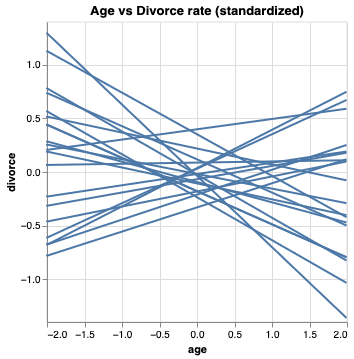

In [11]:
# plot samples from prior for age vs divorce: A -> D

# standardized
age_grid = np.linspace(-2, 2, num=100)

df = pd.DataFrame({"age": [], "divorce": [], "sample": []})
for i in range(20):
    alpha = fit_df["alpha"][i]
    betaA = fit_df["betaA"][i]
    d = alpha + betaA * age_grid

    sample = np.full_like(d, str(i), dtype=object)
    line_df = pd.DataFrame({"age": age_grid, "divorce": d, "sample": sample})
    df = pd.concat([df, line_df])

lines_chart = (
    alt.Chart(df, title="Age vs Divorce rate (standardized)")
    .mark_line()
    .encode(x="age", y="divorce", detail="sample")
)
lines_chart

#### Fit the model

In [12]:
code = """
data {
  int<lower=0> n;
  vector[n] marriage;
  vector[n] divorce;
  vector[n] age;
}
parameters {
  real alpha;
  real betaM;
  real betaA;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 0.2);
  betaM ~ normal(0, 0.5);
  betaA ~ normal(0, 0.5);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + betaM * marriage + betaA * age;
  divorce ~ normal(mu, sigma);
}
"""

data = {"n": len(divorce), "marriage": marriage, "divorce": divorce, "age": age}

In [13]:
%%capture
with suppress_subprocess_output():
    posterior = stan.build(code, data=data, random_seed=42)

In [14]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [15]:
fit_df = fit.to_frame()
fit_df[["alpha", "betaM", "betaA", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,-0.000011,0.099064,-0.391533,-0.064280,-0.000227,0.064338,0.340230
betaM,4000.0,-0.061745,0.158937,-0.663839,-0.174210,-0.061993,0.047671,0.553932
betaA,4000.0,-0.604188,0.157951,-1.115916,-0.714291,-0.603590,-0.494197,-0.029971
sigma,4000.0,0.834818,0.084447,0.610820,0.775793,0.827711,0.885704,1.245695


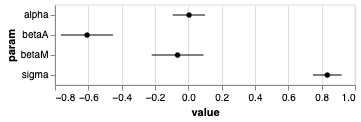

In [16]:
dfs = []

for param in ["alpha", "betaM", "betaA", "sigma"]:
    val = fit_df[param][:1000]
    df = pd.DataFrame({"param": np.full_like(val, param, dtype=object), "value": val})
    dfs.append(df)

df = pd.concat(dfs)
error_bars = alt.Chart(df).mark_errorbar(extent="stdev").encode(x="value", y="param")

points = (
    alt.Chart(df)
    .mark_point(filled=True, color="black")
    .encode(
        x=alt.X("value", aggregate="mean"),
        y="param",
    )
)

error_bars + points

## The Pipe

X -> Z -> Y

The pipe statistically looks very similar to the Fork but structurally (DAG) it is very different. If just looking at the data the Fork and the Pipe would look the same.

### Estimate **total** casual effect of treatment (estimand) on plant growth

**Model:**
```
T────►H1◄────H0
│     ▲        
│     │        
│     │        
└────►F        
```

`T` - treatment

`F` - fungus level

`H1` - final height at the end of the experiment

`H0` - initial height before the experiment


**Implications:**

`T -> H1` - treatment may impact plant growth directly, eg by being toxic

`T -> F -> H1` - the pipe with `F` as a mediator.

`H0 -> H1` - the higher initial height, the higher the final height we expect

We want to estimate total `T -> H1`, IOW `H1 = f(T)`. 

If we would stratify by `F`, we would estimate direct effect `T -> H1` and block `T -> F -> H1`. IOW, `H1 = f(T, F)`.

In [17]:
# Generate synthetic data so we have exact casual model. See page 175
n = 100  # number of plants

h0 = np.random.normal(10, 2, size=(n,))  # initial height

# assign treatment to plants
treatment = np.repeat([0, 1], n // 2)  # first half no treatment, second half treatment

# presence of fungus in each plant, treatment lowers fungus
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=(n,))

# final height, fungus reduces growth
h1 = h0 + np.random.normal(5 - 3 * fungus, size=(n,))

# growth proportion
p = h1 / h0

In [18]:
# growth rate adjustment due to treatment
(p[treatment == 1] - p[treatment == 0]).mean()

np.float64(0.07149809689963407)

In [19]:
# default growth rate
p[fungus == 0].mean()

np.float64(1.5154497130889542)

### Estimate total effect T -> H1

Without stratifying by "F"

In [20]:
code = """
data {
  int<lower=0> n;         // number of plants
  vector[n] h0;           // initial height
  vector[n] h1;           // final height
  vector[n] treatment;    // plant treatment status
}
parameters {
  real<lower=0> a;     // default growth rate
  real bt;             // growth rate correction due to treatment
  real<lower=0> sigma;
}
model {
  // priors
  a ~ lognormal(0, 0.2);
  bt ~ normal(0, 0.5);
  sigma ~ exponential(1);
  
  // likelihood
  vector[n] p = a + bt * treatment;
  vector[n] myu = h0 .* p;
  h1 ~ normal(myu, sigma);
}
"""

data = {"n": n, "h0": h0, "h1": h1, "treatment": treatment}

In [21]:
%%capture
with suppress_subprocess_output():
    posterior = stan.build(code, data=data, random_seed=42)

In [22]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [23]:
fit_df = fit.to_frame()
fit_df[["a", "bt", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
a,4000.0,1.358462,0.026068,1.255590,1.341653,1.358063,1.375972,1.447084
bt,4000.0,0.050475,0.036909,-0.079171,0.025782,0.050999,0.075073,0.196331
sigma,4000.0,1.878590,0.137244,1.475071,1.782958,1.871186,1.963076,2.528877


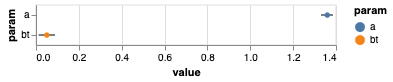

In [24]:
df = fit_df[["a", "bt"]][:2500]
df = df.melt(var_name="param")

error_bars = alt.Chart(df).mark_errorbar(extent="stdev").encode(x="value", y="param")

points = (
    alt.Chart(df)
    .mark_point(filled=True, color="black")
    .encode(x=alt.X("value", aggregate="mean"), y="param", color="param")
)

error_bars + points

### Estimate direct effect of T -> H1

Stratify by `F`, IOW `H1 = f(T, F)`. Expect to see no impact of treatment on plant growth.

In [25]:
code = """
data {
  int<lower=0> n;         // number of plants
  vector[n] h0;           // initial height
  vector[n] h1;           // final height
  vector[n] treatment;    // plant treatment status
  vector[n] fungus;       // presence of fungus
}
parameters {
  real<lower=0> a;     // default growth rate
  real bt;             // growth rate correction due to treatment
  real bf;             // growth rate correction due to fungus
  real<lower=0> sigma;
}
model {
  // priors
  a ~ lognormal(0, 0.2);
  bt ~ normal(0, 0.5);
  bf ~ normal(0, 0.5);
  sigma ~ exponential(1);
  
  // likelihood
  vector[n] p = a + bt * treatment + bf * fungus;
  vector[n] myu = h0 .* p;
  h1 ~ normal(myu, sigma);
}
"""

data = {"n": n, "h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus}

In [26]:
%%capture
with suppress_subprocess_output():
    posterior = stan.build(code, data=data, random_seed=42)

In [27]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [28]:
fit_df = fit.to_frame()
fit_df[["a", "bt", "bf", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
a,4000.0,1.490193,0.020517,1.412240,1.476357,1.489995,1.503676,1.563857
bt,4000.0,-0.025893,0.025555,-0.127051,-0.042444,-0.024924,-0.008618,0.055852
bf,4000.0,-0.307443,0.027425,-0.399105,-0.325930,-0.307586,-0.289378,-0.190743
sigma,4000.0,1.241083,0.092907,0.981792,1.175663,1.235455,1.299643,1.644288


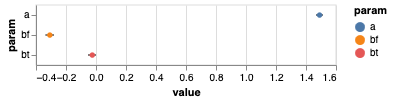

In [29]:
df = fit_df[["a", "bt", "bf"]][:1600]
df = df.melt(var_name="param")

error_bars = alt.Chart(df).mark_errorbar(extent="stdev").encode(x="value", y="param")

points = (
    alt.Chart(df)
    .mark_point(filled=True, color="black")
    .encode(x=alt.X("value", aggregate="mean"), y="param", color="param")
)

error_bars + points

## The Collider

`X -> Z <- Y` where `Z` is a collider. `X` and `Y` are not associated (`P(X|Y) = P(X)`) but if we condition on `Z` it gives us information about `P(X|Y,Z)` or `P(Y|X,Z)` since knowing 2 out of 3 variables limits what the remaining variable could be.

### Does Age Influence Happiness? A -> H

`Happiness -> Marriage <- Age`. See page 180.

In [30]:
# Generate synthetic data so we have exact casual model.
happy_df = sr.sim_happiness(seed=1977, N_years=100)
happy_df.head(5)

,age,married,happiness
0,65,0,-2.000000
1,65,0,-1.789474
2,65,1,-1.578947
3,65,0,-1.368421
4,65,0,-1.157895


In [31]:
happy_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1300.0,3.300000e+01,18.768883,1.0,17.0,3.300000e+01,49.0,65.0
married,1300.0,2.984615e-01,0.457759,0.0,0.0,0.000000e+00,1.0,1.0
happiness,1300.0,-8.335213e-17,1.214421,-2.0,-1.0,-1.110223e-16,1.0,2.0


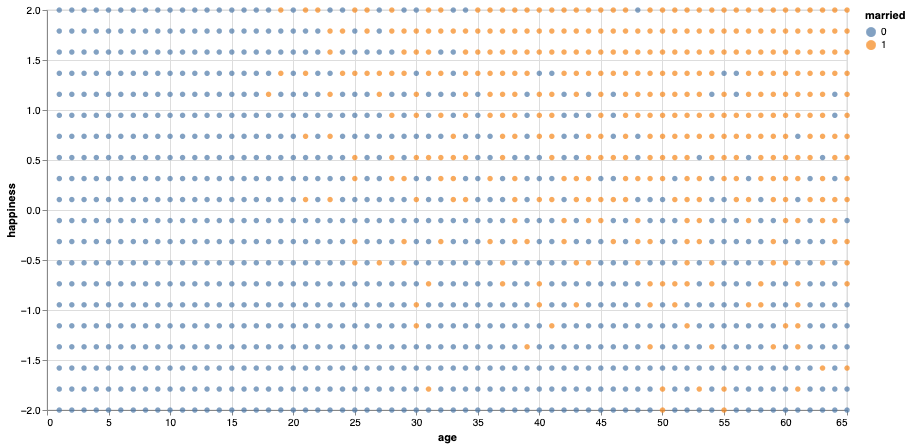

In [32]:
happy_chart = (
    alt.Chart(happy_df)
    .mark_point(filled=True)
    .encode(x="age", y="happiness", color="married:N")
).properties(width=800, height=400)
happy_chart

In [33]:
# select adults who can marry
happy_adult_df = happy_df[happy_df["age"] >= 18]

# normalize variables
happiness = happy_adult_df["happiness"].to_numpy()  # [-2, 2]
age = happy_adult_df["age"].to_numpy()
age = (age - age.min()) / (age.max() - age.min())  # [0, 1]
married = happy_adult_df["married"].to_numpy() + 1  # {1, 2}

In [34]:
# A model where we control for marriage: H = f(A, M).
# Expect to see false association between A and H
code = """
data {
  int<lower=0> n;      // number of people
  vector[n] happiness;
  vector[n] age;
  array[n] int married;
}
parameters {
  vector[2] alpha;     // intercept of mean happiness
  real beta;           // slope of mean happiness
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 1);
  beta ~ normal(0, 2);
  sigma ~ normal(10, 5);

  // likelihood
  for (i in 1:n) {
      real mu = alpha[married[i]] + beta * age[i];
      happiness[i] ~ normal(mu, sigma);
  }
}
"""

data = {"n": len(age), "happiness": happiness, "age": age, "married": married}

In [35]:
%%capture
with suppress_subprocess_output():
    posterior = stan.build(code, data=data, random_seed=42)

In [36]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [37]:
fit_df = fit.to_frame()
fit_df[["alpha.1", "alpha.2", "beta", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha.1,4000.0,-0.205235,0.063651,-0.435840,-0.246971,-0.205538,-0.161861,0.042364
alpha.2,4000.0,1.251568,0.084483,0.933399,1.193172,1.251922,1.310088,1.523048
beta,4000.0,-0.769876,0.112531,-1.148599,-0.846458,-0.770410,-0.692416,-0.380296
sigma,4000.0,1.007472,0.023621,0.934280,0.991208,1.007242,1.022786,1.096271


In [38]:
# plot posterior mean regression lines
age_grid = np.linspace(0, 1, num=50)

alpha_unmarried = fit_df["alpha.1"].mean()
alpha_married = fit_df["alpha.2"].mean()
beta = fit_df["beta"].mean()
sigma = fit_df["sigma"].mean()

# real mu = alpha[married[i]] + beta * age[i];
happy_unmarried = alpha_unmarried + beta * age_grid
happy_married = alpha_married + beta * age_grid

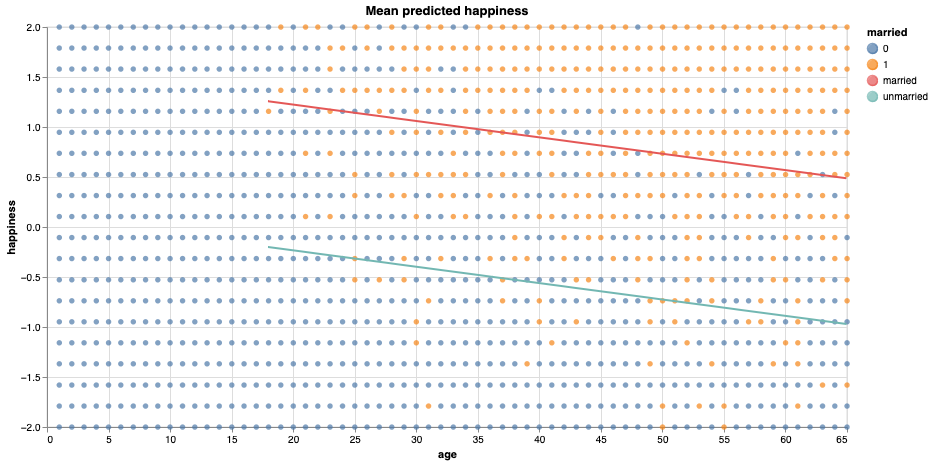

In [39]:
min_age = happy_adult_df["age"].min()
max_age = happy_adult_df["age"].max()

age_grid_unscaled = age_grid * (max_age - min_age) + min_age

df = pd.DataFrame(
    {"age": age_grid_unscaled, "unmarried": happy_unmarried, "married": happy_married}
)
df = df.melt("age", var_name="married", value_name="happiness")

lines_chart = (
    alt.Chart(df, title="Mean predicted happiness")
    .mark_line(strokeWidth=2)
    .encode(x="age", y=alt.Y("happiness"), color="married")
)

happy_chart + lines_chart

In [40]:
# Compare with a model that omits marriage status: H = f(A)
# Expect to see no association between A and H
code = """
data {
  int<lower=0> n;      // number of people
  vector[n] happiness;
  vector[n] age;
}
parameters {
  real alpha;          // intercept of mean happiness
  real beta;           // slope of mean happiness
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 1);
  beta ~ normal(0, 2);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + beta * age;
  happiness ~ normal(mu, sigma);
}
"""

data = {"n": len(age), "happiness": happiness, "age": age}

In [41]:
%%capture
with suppress_subprocess_output():
    posterior = stan.build(code, data=data, random_seed=42)

In [42]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [43]:
fit_df = fit.to_frame()
fit_df[["alpha", "beta", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,0.001270,0.077615,-0.268660,-0.052362,-0.001188,0.053805,0.348039
beta,4000.0,-0.001632,0.133499,-0.547308,-0.093579,0.000676,0.091790,0.490681
sigma,4000.0,1.214829,0.027779,1.113653,1.195586,1.214163,1.232562,1.344381


## The Descendant

```
X ───►Z────►Y
      │      
      │      
      ▼      
      A      
```
`A` is a descendant. `X` and `Y` are associated through `Z`. If we condition on `A` we would learn something about `Z` and therefore weaken `X` and `Y` association.